<a href="https://colab.research.google.com/github/hectic97/Boostcamp-AI-Tech/blob/main/U-stage/Week8/pytorch_to_tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements

In [1]:
!pip install onnx==1.7.0
!pip install Pympler
!pip install onnx-tf==1.6.0
!pip install tensorflow==2.2.0
!pip install tensorflow-addons==0.11.2
# !pip install torch==1.5.1
# !pip install torchvision==0.6.1

     |████████████████████████████████| 7.4MB 3.1MB/s 
     |████████████████████████████████| 184kB 5.8MB/s 
  Created wheel for Pympler: filename=Pympler-0.9-cp37-none-any.whl size=164804 sha256=b800be79b476788948f6a47b59e29835f68f312bb6ae0e9a3acbef2683b95474
  Stored in directory: /root/.cache/pip/wheels/23/15/5a/90dd23b3ceffcf8463dc737fba4fad3e295d1da52622bbb74f
Successfully built Pympler
     |████████████████████████████████| 194kB 4.2MB/s 
     |████████████████████████████████| 516.2MB 32kB/s 
     |████████████████████████████████| 460kB 40.2MB/s 
     |████████████████████████████████| 3.0MB 47.8MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
   


## Alexnet

alexnet을 cifar10에 맞게 구조를 변경합니다.


<center><img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99FEB93C5C80B5192E' ,description="AlexNet 구조", width=60%></center>
<center><em>AlexNet의 구조</em></center>

In [2]:
import torch
import torchvision
import torch.nn as nn

# dummy_input = torch.randn(10, 3, 224, 224, device='cuda')
dummy_input = torch.randn(10, 3, 224, 224, device='cpu')
model = torchvision.models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(4096, 10) # replace 1000 classes into 10 classes for cifar10
# model = model.cuda()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


데이터셋 및 전처리 코드를 작성합니다.

In [3]:
# train with cifar10
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Resize((224, 224)), # dataset을 모델의 구조와 맞게 resize해줍니다.
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]
)


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True)


Extracting ./data/cifar-10-python.tar.gz to ./data


EDA를 진행합니다.

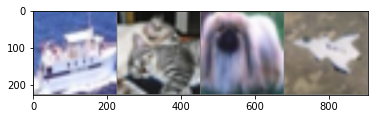

 ship   cat   dog plane


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images[0:4]))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

학습을 진행합니다.

In [5]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [8]:
# [참고] epoch을 10으로 두면 다 도는데 오래 걸립니다. 강의에서는 epoch을 1로 진행합니다.
# for epoch in range(10): # 데이터셋을 수차례 반복해서 넣습니다.
for epoch in range(1):   
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        # break
        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        # inputs = inputs.cuda()
        # labels = labels.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
print('Training is done')

Training is done


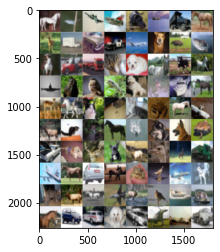

In [9]:
imshow(torchvision.utils.make_grid(inputs.cpu()))

In [10]:
inference_torch = model(inputs).detach().cpu().numpy() # Inference for each image

In [11]:
model(inputs)[0] # check the first inference

tensor([-0.6829, -0.8980,  0.4117, -0.1389,  0.3277,  0.1002, -0.1244,  1.0754,
        -2.9924, -0.6938], grad_fn=<SelectBackward>)

In [12]:
labels = labels.double().detach().cpu().numpy() # send labels to cpu
output = torch.Tensor([torch.argmax(inp).item() for inp in model(inputs)]).numpy() # send output to cpu
print(labels)
print(output)

[7. 2. 0. 0. 5. 8. 9. 7. 4. 9. 1. 1. 0. 5. 2. 8. 7. 1. 9. 3. 5. 7. 7. 7.
 0. 7. 2. 6. 5. 4. 8. 7. 4. 7. 3. 3. 3. 6. 7. 0. 4. 3. 3. 7. 8. 5. 5. 6.
 1. 5. 4. 5. 4. 2. 4. 9. 0. 7. 1. 7. 6. 2. 0. 5. 3. 4. 7. 0. 4. 2. 8. 8.
 7. 1. 1. 5. 1. 0. 8. 9.]
[7. 0. 0. 0. 5. 0. 9. 7. 7. 8. 9. 1. 0. 5. 7. 8. 5. 1. 1. 5. 5. 0. 7. 7.
 0. 5. 5. 4. 5. 2. 8. 7. 7. 9. 5. 7. 7. 4. 7. 2. 7. 9. 7. 7. 8. 5. 5. 4.
 1. 6. 5. 2. 4. 5. 7. 0. 0. 7. 9. 7. 6. 2. 0. 5. 4. 4. 0. 2. 2. 0. 8. 8.
 7. 1. 1. 5. 9. 7. 8. 9.]


In [13]:
np.sum(labels==output)

41

## gdrive에 접근하기

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


모델을 저장합니다.

In [15]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/model.pt') # 217.61MB 

## Model Compile

torch를 onnx로 변경합니다.

In [16]:
input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
output_names = [ "output1" ]

torch.onnx.export(model.cpu(), dummy_input.cpu(), "alexnet.onnx", verbose=True, input_names=input_names, output_names=output_names)

graph(%actual_input_1 : Float(10, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu),
      %learned_0 : Float(64, 3, 11, 11, strides=[363, 121, 11, 1], requires_grad=1, device=cpu),
      %learned_1 : Float(64, strides=[1], requires_grad=1, device=cpu),
      %learned_2 : Float(192, 64, 5, 5, strides=[1600, 25, 5, 1], requires_grad=1, device=cpu),
      %learned_3 : Float(192, strides=[1], requires_grad=1, device=cpu),
      %learned_4 : Float(384, 192, 3, 3, strides=[1728, 9, 3, 1], requires_grad=1, device=cpu),
      %learned_5 : Float(384, strides=[1], requires_grad=1, device=cpu),
      %learned_6 : Float(256, 384, 3, 3, strides=[3456, 9, 3, 1], requires_grad=1, device=cpu),
      %learned_7 : Float(256, strides=[1], requires_grad=1, device=cpu),
      %learned_8 : Float(256, 256, 3, 3, strides=[2304, 9, 3, 1], requires_grad=1, device=cpu),
      %learned_9 : Float(256, strides=[1], requires_grad=1, device=cpu),
      %learned_10 : Float(4096, 9216, strides

In [18]:
import onnx
model = onnx.load("alexnet.onnx")
# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
onnx.helper.printable_graph(model.graph)

'graph torch-jit-export (\n  %actual_input_1[FLOAT, 10x3x224x224]\n) initializers (\n  %learned_0[FLOAT, 64x3x11x11]\n  %learned_1[FLOAT, 64]\n  %learned_2[FLOAT, 192x64x5x5]\n  %learned_3[FLOAT, 192]\n  %learned_4[FLOAT, 384x192x3x3]\n  %learned_5[FLOAT, 384]\n  %learned_6[FLOAT, 256x384x3x3]\n  %learned_7[FLOAT, 256]\n  %learned_8[FLOAT, 256x256x3x3]\n  %learned_9[FLOAT, 256]\n  %learned_10[FLOAT, 4096x9216]\n  %learned_11[FLOAT, 4096]\n  %learned_12[FLOAT, 4096x4096]\n  %learned_13[FLOAT, 4096]\n  %learned_14[FLOAT, 10x4096]\n  %learned_15[FLOAT, 10]\n) {\n  %17 = Conv[dilations = [1, 1], group = 1, kernel_shape = [11, 11], pads = [2, 2, 2, 2], strides = [4, 4]](%actual_input_1, %learned_0, %learned_1)\n  %18 = Relu(%17)\n  %19 = MaxPool[kernel_shape = [3, 3], pads = [0, 0, 0, 0], strides = [2, 2]](%18)\n  %20 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [2, 2, 2, 2], strides = [1, 1]](%19, %learned_2, %learned_3)\n  %21 = Relu(%20)\n  %22 = MaxPool[kernel_sha

## 버전이슈 생각해보기

현재 노트북은 버전이슈를 해결한 상태입니다. 하지만, 만약에 버전이슈가 있었다면, 어떻게 해결할지 고민해보면 좋을 듯힙니다.

ex) github issue

In [19]:
# onnx to tensorflow graph
from onnx_tf.backend import prepare
import onnx

In [21]:
tf_rep = prepare(model)

2021-03-16 23:03:19,641 - onnx-tf - INFO - Fail to get since_version of BitShift in domain `` with max_inclusive_version=9. Set to 1.
2021-03-16 23:03:19,643 - onnx-tf - INFO - Fail to get since_version of ConcatFromSequence in domain `` with max_inclusive_version=9. Set to 1.
2021-03-16 23:03:19,645 - onnx-tf - INFO - Unknown op ConstantFill in domain `ai.onnx`.
2021-03-16 23:03:19,646 - onnx-tf - INFO - Fail to get since_version of ConvInteger in domain `` with max_inclusive_version=9. Set to 1.
2021-03-16 23:03:19,647 - onnx-tf - INFO - Fail to get since_version of CumSum in domain `` with max_inclusive_version=9. Set to 1.
2021-03-16 23:03:19,648 - onnx-tf - INFO - Fail to get since_version of DequantizeLinear in domain `` with max_inclusive_version=9. Set to 1.
2021-03-16 23:03:19,649 - onnx-tf - INFO - Fail to get since_version of Det in domain `` with max_inclusive_version=9. Set to 1.
2021-03-16 23:03:19,651 - onnx-tf - INFO - Fail to get since_version of DynamicQuantizeLinear 

KeyboardInterrupt: ignored

In [ ]:
tf_rep.export_graph('/content/gdrive/MyDrive/model.pb') # 233MB

## TFlite

In [ ]:
import tensorflow as tf

In [ ]:
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    '/content/gdrive/MyDrive/model.pb',
    input_arrays=input_names,
    output_arrays=output_names,
)

In [ ]:
converter.experimental_new_converter = True # Experimental flag, subject to change. Enables MLIR-based conversion instead of TOCO conversion. (default True)

In [ ]:
converter.target_spec.supported_ops = [
                                       tf.compat.v1.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.compat.v1.lite.OpsSet.SELECT_TF_OPS,
]

In [ ]:
tf_lite_model = converter.convert()

In [ ]:
with open('/content/gdrive/MyDrive/model.tflite', 'wb') as f:
    f.write(tf_lite_model) # 14KB

## Reference

https://towardsdatascience.com/my-journey-in-converting-pytorch-to-tensorflow-lite-d244376beed